In [95]:
#Die ganzen packages die für den versuch verwendet werden

import numpy as np #numpy ist ein package mit allen mathematischen ausdrücken/funktionen/operationen/etc. 
from uncertainties import ufloat #Uncertainties ist für das automatische berrechnen von unsicherheiten
from uncertainties.umath import * #Importieren von rechnen mit uncertainties (addition/multiplikation/etc.)
from uncertainties import unumpy as unp #kann arrays von unsicherheiten verstehen (also eine liste, statt jede zahl einzeln einzutippen)
from IPython.display import Latex, HTML, Math, display # Um ergebnisse schöner anzuzeigen. display() "ersetzt" quasi print(), und lässt latex fromatierung zu
import matplotlib.pyplot as plt #Damit kann man graphen plotten

import pandas as pd #Um die Spektroskopie daten zu lesen
from scipy.signal import find_peaks #um die maxima von listen (also auch y-achse) zu finden


#funktion für mittwlert mit fehler defnieren (um später ein uarray mit unsicherheiten direkt zu einem mittelwert zu machen)
def mean(values):
    nom = unp.nominal_values(values)
    std_mean = np.std(nom, ddof=1) / np.sqrt(len(nom))
    return ufloat(np.mean(nom), std_mean)



# Brechung, Dispersion und Spektroskopie

## Dispersionskurve eines optischen Glases

Es wird die Disperionskurve eines Optischen Glases mittels Spektroskopie bestimmt.

### Grundlagen

### Durchführung und Aufbau

### Ergebnisse

Die mittels Goniometer bestimmten Minimal Winkel und den Dementsprechenden Brechungsindizes sind in Tabelle 1. angeführt.

In [68]:
#Goniometer: Spektrallinien einer Quecksilberlampe

#Spektrallinien Winkel:

# Unsicherheit vom winkel nach augenmaß (höher als auflösung vom goniometer = 0.01)
Winkel_std = 0.1
# Epsilon winkel vom Prisma:
e = 60

#                          Lila     Blau   Grün    Gelb
ungebrochen = unp.uarray([ 90.64 , 91.73 , 92.10 , 92.95 ], Winkel_std)
gebrochen   = unp.uarray([ 41.31 , 41.96 , 42.48 , 43.05 ], Winkel_std)

delta_min = ungebrochen - gebrochen
n = unp.sin((delta_min + e)/2 * np.pi/180) / unp.sin(e/2 * np.pi/180) # * np.pi/180 weil np.sin nur mit Bogenmaß arbeitet (!!!nicht mit winkelmaß!!!)


#----------------------------------------------------------------------------------------------------------------------------------------------
#
# Ab hier alles nur um die Tabellen schön darzustellen. Man könnte auch einfach print(n) und print(delta_min) machen ist aber uuuurrrr schirch
#
#----------------------------------------------------------------------------------------------------------------------------------------------


meine_lieblingsfarben = (["Lila", "Blau", "Grün", "Gelb"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Min. Winkel} ~\delta_{min}~\mathrm[°] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Delta,n) in enumerate(zip(meine_lieblingsfarben, delta_min, n)):
    table += rf"\mathrm{{{farbe}}} & ({Delta:.2f}) & ({n:.3f}) \\ "
table += r"\end{array}$$"

display(Latex(table))

<IPython.core.display.Latex object>

Spektrometer blablablbalbalbalb

In [93]:
#Farbige wellenlänge

#dieser code ist nur um Spektrum farbig zu machen

def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255
    factor = 0.0
    R = G = B = 0

    if 300 <= wavelength < 440:
        R = -(wavelength - 440) / (440 - 300)
        G = 0.0
        B = 1.0
    elif 440 <= wavelength < 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 <= wavelength < 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 <= wavelength <= 780:
        R = 1.0
        G = 0.0
        B = 0.0

    if 300 <= wavelength < 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 300)
    elif 420 <= wavelength < 645:
        factor = 1.0
    elif 645 <= wavelength <= 780:
        factor = 0.3 + 0.7 * (780 - wavelength) / (780 - 645)

    R = ((R * factor) ** gamma)
    G = ((G * factor) ** gamma)
    B = ((B * factor) ** gamma)

    return (R, G, B)

/tmp/ipykernel_15077/75530028.py:43: RuntimeWarning: invalid value encountered in scalar power
  R = ((R * factor) ** gamma)
/tmp/ipykernel_15077/75530028.py:45: RuntimeWarning: invalid value encountered in scalar power
  B = ((B * factor) ** gamma)


<IPython.core.display.Latex object>

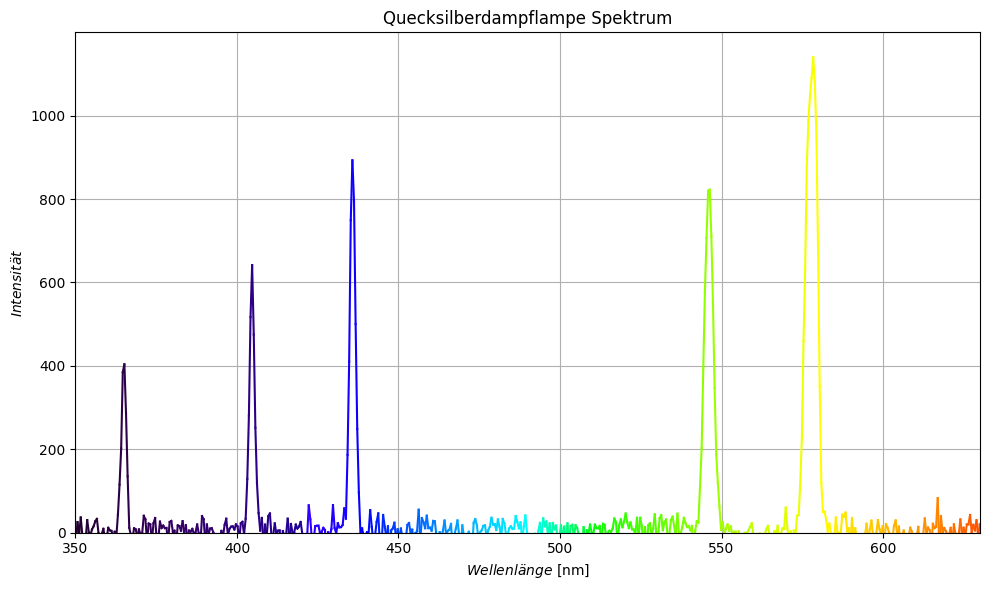

In [113]:
#Spektrum der Quecksilberdampflampe


Spektrum = pd.read_csv("GPT-Data.csv", sep=',', decimal='.')


wellenlänge_wert = Spektrum['Wavelength(nm)'].values
wellenlänge = wellenlänge_wert
Int = Spektrum['Intensity'].values


# Create a color list for each wavelength
colors = [wavelength_to_rgb(wl) for wl in wellenlänge]

# Plot with color gradient
plt.figure(figsize=(10, 6))
for i in range(len(wellenlänge) - 1):
    plt.plot(wellenlänge[i:i+2], Int[i:i+2], color=colors[i])

plt.xlabel("$Wellenlänge$ [nm]")
plt.ylabel("$Intensität$")
plt.title("Quecksilberdampflampe Spektrum")
plt.ylim(bottom=-0.1)
plt.xlim(left=350, right=630)
plt.grid()
plt.tight_layout()

ranges = [(380, 415), (420, 450), (540, 550), (580, 600)]
peak_positions = []
peak_values = []


#Die maxima aus den Daten bestimmen
for r in ranges:
    mask = (wellenlänge >= r[0]) & (wellenlänge < r[1])
    peaks, _ = find_peaks(Int[mask])
    if len(peaks) > 0:
        # get index of highest peak in this range
        local_max_idx = peaks[np.argmax(Int[mask][peaks])]
        peak_positions.append(wellenlänge[mask][local_max_idx])
        peak_values.append(Int[mask][local_max_idx])


meine_lieblingsfarben = (["Lila", "Blau", "Grün", "Gelb"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Min. Winkel} ~\delta_{min}~\mathrm[°] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Peak) in enumerate(zip(meine_lieblingsfarben, peak_values)):
    table += rf"\mathrm{{{farbe}}} & ({Peak:.2f}) & ({n:.3f}) \\ "
table += r"\end{array}$$"

display(Latex(table))
